In [3]:
import numpy as np
import copy as c
import matplotlib as m
import matplotlib.pyplot as plt
import pickle as pkl
import sklearn as skl
from sklearn.model_selection import train_test_split as splt
import sklearn.metrics as mtr
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as cfm
from sklearn.ensemble import RandomForestClassifier as rfc
import scipy.stats as sct
import scipy.optimize as sco
import gromacs as gmx
from tqdm import tqdm
from itertools import combinations

/home/jayakrishnak/softwares/anaconda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NOTE: Some configuration directories are not set up yet: 
	/home/jayakrishnak/.gromacswrapper
	/home/jayakrishnak/.gromacswrapper/qscripts
	/home/jayakrishnak/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


# Datas

In [2]:
cpairs = np.loadtxt('../1_contact_pairs/contact_pairs.txt',dtype='str')

In [14]:
labels = np.concatenate(np.load('../3_data_labels/labels.npy',allow_pickle=True))

In [18]:
features = []
for t in tqdm([1,2,3]):
    for s in ['open','closed']:
        pfeatures = []
        for cp in cpairs:
            dd = np.load('../2_mindist_files/numpy_converted_files/mindist_r'+cp[0]+'_r'+cp[1]+'_apo_'+s+'_'+str(t)+'.npy')
            if len(pfeatures) == 0:
                pfeatures = c.deepcopy(dd)
            else:
                pfeatures = np.column_stack((pfeatures,dd))
                
        if len(features) == 0:
            features = c.deepcopy(pfeatures)
        else:
            features = np.concatenate((features,pfeatures))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [1:34:50<00:00, 1896.83s/it]


In [20]:
np.save('features.npy',features)
np.save('labels.npy',labels)

# RF

In [43]:
ftrain, ftest, ltrain, ltest = splt(features, labels, test_size=0.3, random_state=0)

In [32]:
clf0 = rfc(n_estimators=1000, n_jobs=16, random_state=0)

In [33]:
clf0.fit(ftrain, ltrain)

RandomForestClassifier(n_estimators=1000, n_jobs=16, random_state=0)

In [38]:
pkl.dump(clf0,open('model_0.pkl','wb'))

In [44]:
predicted_train0 = clf0.predict(ftrain)
predicted_test0 = clf0.predict(ftest)

In [35]:
acc(ltrain,predicted_train0)

1.0

In [36]:
acc(ltest,predicted_test0)

0.9979339701442925

In [45]:
cfm(ltest, predicted_test0)

array([[321832,     65,      0],
       [   152, 332626,    712],
       [     0,    513,  42057]])

## for cross validation

In [39]:
n=49
randoms=np.zeros((n))
for i in range(n):
    randoms[i] = np.random.randint(1,1000)

In [41]:
randoms

array([115., 283.,  48., 238., 286., 781.,  43., 819., 392.,   4., 580.,
        37., 290., 932., 985., 238., 850., 637., 979., 803., 676., 496.,
       925., 735., 898., 722., 164., 234., 680.,  35., 762., 350., 646.,
       223., 672., 218., 680., 401., 689., 668., 897., 380., 861., 273.,
       356., 632., 146., 299., 100.])

In [46]:
np.save('randoms.npy',randoms)

# analysis

In [64]:
cpairs = np.loadtxt('../1_contact_pairs/contact_pairs.txt', dtype=str)

In [65]:
top95_features = []
cutoff = 0.95

for m in tqdm(range(50)):
    
    if m==0: clf = pkl.load(open('model_0.pkl','rb'))
    else: clf = pkl.load(open(f'1_cross_validation/model_{m}.pkl', 'rb'))
        
    fimportances = clf.feature_importances_
    findexes = fimportances.argsort()[::-1]
    fimportances = fimportances[findexes]
    lindex = np.where( np.cumsum(fimportances) >= cutoff )[0][0]
    fimportances = np.column_stack(( findexes[:lindex], fimportances[:lindex] ))
    top95_features.append(fimportances)
    
top95_features = np.array(top95_features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]
/tmp/ipykernel_22337/3025286821.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top95_features = np.array(top95_features)


In [66]:
nreplicas = 50

common_top95_features = []
dd = np.concatenate((top95_features))[:,0].astype(int)
for i in np.unique(dd):
    if len(np.where(dd == i)[0]) == nreplicas:
        common_top95_features.append(i)

nfeatures_top95 = []
diff_importances_top95 = []
for i in range(nreplicas):
    nfeatures_top95.append( top95_features[i].shape[0] )
    
    ss = 0
    for j in top95_features[i]:
        if j[0] not in common_top95_features:
            ss += j[1]
    diff_importances_top95.append(ss/0.95)
    
nfeatures_top95 = [ np.mean(nfeatures_top95), np.std(nfeatures_top95) ]
diff_importances_top95 = [ np.mean(diff_importances_top95), np.std(diff_importances_top95) ]

In [67]:
nfeatures_top95

[245.22, 2.0908371529126795]

In [68]:
diff_importances_top95

[0.04165230795571352, 0.001753723014654573]

In [69]:
all_top95_features = {}
for i in range(nreplicas):
    for j in top95_features[i]:
        if int(j[0]) not in all_top95_features.keys():
            all_top95_features[int(j[0])] = []
        all_top95_features[int(j[0])].append(j[1])

major_top95_features = {}
for key in all_top95_features:
    if len(all_top95_features[key]) > 45:
        major_top95_features[key] = [ np.mean(all_top95_features[key]), np.std(all_top95_features[key]) ]

In [27]:
len(major_top95_features)

206

In [9]:
features = np.load('features.npy')

In [10]:
labels = np.load('labels.npy')

In [14]:
major_features95 = features[:, list(major_top95_features.keys())]
features = 0

In [15]:
features95_closed = major_features95[ np.where(labels == 0)[0] ]
features95_int = major_features95[ np.where(labels == 1)[0] ]
features95_open = major_features95[ np.where(labels == 2)[0] ]

major_features95 = 0

In [16]:
means95_open = np.zeros(( len(major_top95_features.keys()) ))
means95_int = np.zeros(( len(major_top95_features.keys()) ))
means95_closed = np.zeros(( len(major_top95_features.keys()) ))

for i in tqdm(range(len(major_top95_features.keys()))):
    means95_closed[i] = np.mean(features95_closed[:,i])
    means95_int[i] = np.mean(features95_int[:,i])
    means95_open[i] = np.mean(features95_open[:,i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:23<00:00,  8.82it/s]


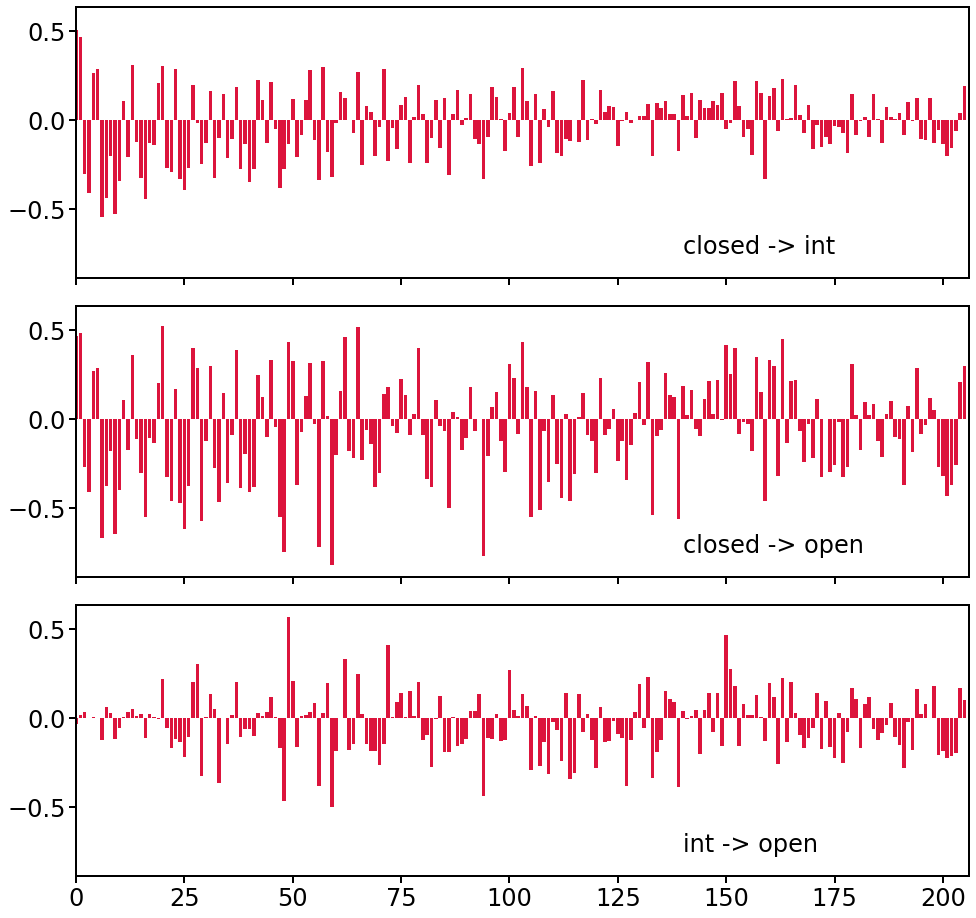

In [46]:
fig,ax = plt.subplots(3,1, figsize=(16,16), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1)
ax[0].set_xlim(0,206)
k=-1
for i in combinations(['closed', 'int', 'open'], 2):
    k+=1
    dd = eval(f'means95_{i[0]}') - eval(f'means95_{i[1]}')
    ax[k].bar(range(len(major_top95_features.keys())), dd, color='crimson')
    ax[k].spines[:].set_linewidth(2)
    ax[k].tick_params(labelsize=24, length=7, width=2)
    ax[k].text(140, -0.75, f'{i[0]} -> {i[1]}', fontsize=24)
plt.show()

In [21]:
np.save('saved_files/major_top95_features.npy' ,np.column_stack(( list(major_top95_features.keys()) , list(major_top95_features.values()) )) )

In [23]:
np.save('saved_files/means_closed.npy', means95_closed)
np.save('saved_files/means_int.npy', means95_int)
np.save('saved_files/means_open.npy', means95_open)